# <span style='color:#008080'> Preamble  </span> 


This section will always be there for preparing the code used in the particular section. 

## <span style='color:#008080'> Import libraries  </span> 

In the code below we import the necessary libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import xgboost as xgb

from sklearn import tree 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

## <span style='color:#008080'> Data preparation  </span> 

The code below cleans the data before tree algorithms are used on it.

First we make sure that a full sample is obtained.

In [2]:
# Import data 
data_raw = pd.read_csv("../data_ml.csv")

# Clean data to include full samples
idx_date = data_raw.index[(data_raw['date'] > '1999-12-31') & (data_raw['date'] < '2019-01-01')].tolist()
data_ml = data_raw.iloc[idx_date]

Then the features are extracted from the sample dataframe (i.e. independent variables).

In [3]:
# Extract features
features = list(data_ml.iloc[:,3:95].columns) 
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", "Ocf", "Pb", "Vol1Y_Usd"]

The medians are calculated and categorical variables are created when the observered value is above/below the median.

In [4]:
warnings.filterwarnings('ignore')

# Extract relevant data and create placeholder dataframe
col_feat_Div_Yld = data_ml.columns.get_loc('Div_Yld')
is_custom_date = data_ml['date'] == '2000-02-29'
df_median=[]
df=[]

# Calculate medians to use for creating categorical variable
df_median = data_ml[['date','R1M_Usd','R12M_Usd']].groupby(['date']).median() 
df_median.rename(columns = {"R1M_Usd": "R1M_Usd_median", "R12M_Usd": "R12M_Usd_median"},inplace=True)
df = pd.merge(data_ml,df_median,how='left', on=['date'])

# Create categorical variables
data_ml['R1M_Usd_C'] = np.where(df['R1M_Usd'] > df['R1M_Usd_median'], 1.0, 0.0)
data_ml['R12M_Usd_C'] = np.where(df['R12M_Usd'] > df['R12M_Usd_median'], 1.0, 0.0)

# Remove the dataframes again to keep the programme light
df_median=[]
df=[]

Finally, a list a short stock ids is created for concentrated analysis

In [5]:
# Create short id and date list
stock_ids_short=[]
stock_days=[]
stock_ids=data_ml['stock_id'].unique()
stock_days=data_ml[['date','stock_id']].groupby(['stock_id']).count().reset_index()
stock_ids_short=stock_days.loc[stock_days['date'] == (stock_days['date'].max())]
stock_ids_short=stock_ids_short['stock_id'].unique() 

# Extract all stocks and calculate returns
is_stock_ids_short=data_ml['stock_id'].isin(stock_ids_short)  
returns=data_ml[is_stock_ids_short].pivot(index='date',columns='stock_id',values='R1M_Usd') # compute returns in matrix format

# <span style='color:#008080'> Tree based models  </span> 

## <span style='color:#008080'> Simple trees  </span> 

These methods seek to partition data into homogeneous clusturs. Given an exogenous variable $\boldsymbol{Y}$ and features $\boldsymbol{X}$ decision trees iteratively 
splits the sample into groups that are homogenous in $\boldsymbol{Y}$. The splits are made according to one variable within the set of features.

- **Regression tree**: $\boldsymbol{Y}$ consists of real numbers;
- **Classification tree**:  $\boldsymbol{Y}$ is categorical.

<br>

Let sample be ($y_{i}$ and $\mathbf{x}_{i}$) of size $I$. Goal of a **regression tree** is to find splitting point that minimizes total variation in $y_i$ in the two child clusters. First optimal splitting points are first found within each feature $x_{i}^{(k)}$. After it finds the feature that achieves the highest level of homogeneity in $\mathbf{Y}$.

**Homogenity**: Measured by total variation (variance times number of observations), which is summed for each child cluster. This is done since variance is not dependent on amount of observations in each cluster. 

### <span style='color:#008080'> Finding optimal splitting points  </span> 

The first step is to find the best split for each feature. Done by solving $\mathrm{argmin}_{c^{(k)}} V^{(k)}_{I}(c^{(k)})$ with 
\begin{equation}
    V_{I}^{(k)} (c^{(k)}) = \sum_{x_{i}^{(k)} < c^{(k)}} (y_{i} - m_{I}^{k, -}(c^{(k)}))^{2} +  \sum_{x_{i}^{(k)} > c^{(k)}} (y_{i} - m_{I}^{k, +}(c^{(k)}))^{2}, 
\end{equation} 0 
where
\begin{align*}
    m_{I}^{k, -} &= \frac{1}{\# \{ i, x_{i}^{(k)} < c^{(k)} \} } \sum_{\{ x_{i}^{(k)} < c^{(k)} \} } y_{i} \\
    m_{I}^{k, +} &= \frac{1}{\# \{ i, x_{i}^{(k)} > c^{(k)} \} } \sum_{\{ x_{i}^{(k)} > c^{(k)} \} } y_{i}
\end{align*}
are the average values of $\boldsymbol{Y}$ , conditional on $\boldsymbol{X}^{(k)}$ being smaller or larger than $c$. For feature $k$, the optimal split $c^{k,\ast}$ is thus the one for which the total dispersion over the two subgroups is the smallest.

The optimal splits satisfy $c^{k, \ast} = \mathrm{argmin}_{c^{(k)}} V_{I}^{(k)} (c^{(k)})$. Of all the possible splitting variables, the tree will choose the one that minimizes the total dispersion all splits and variables: $k^{\ast} = \mathrm{argmin}_{k} V_{I}^{(k)} (c^{k, \ast})$.


### <span style='color:#008080'> Stop split criteria  </span> 

A lot of different methods exist. Some of them are 
- Fix maximum number of levels (dept) in tree;
- Impose a minimal gain tha tis expected for each split (if split does not improve beyond that threshold it is not executed).

### <span style='color:#008080'> Prediction with simple trees  </span> 

When a tree is built (trained) a new prediction will end up at a leaf in the tree given its feature values. Each leaf has an average value for the label: this is the predicted outcome.

### <span style='color:#008080'> Details on classification  </span> 

When working with classification the largest difference (compared to regression) is the **measure of dispersion/heterogeneity**.

The loss-function must be able to handles outputs that are not numbers, but that are vectors. The output vector, $\tilde{\mathbf{y}}_i$, has the same number of elements as there are categories, and each element represents a probability that a prediction belongs to a category.

Since the aim of trees is homogenity, the **loss function penalizes outputs that are not concentrated towards one class/category**. 

<br>

If there are $J$ classes, we denote the proportions inside each class with $p_{J}$. **Usual loss-functions are**:
- the Gini impurity index: $1- \sum_{j=1}^{J} p_{j}^{2}$;
- the misclassification error: $1 - \max_{j} p_{j}$;
- entropy: $- \sum _{j=1}^{J} \log(p_{j})p_{j}$.


Once the tree is grown, new instances automatically belong to one final leaf. This leaf is associated to the proportions of classes it nests. Usually, to make a prediction, the class with highest proportion (or probability) is chosen when a new instance is associated with the leaf.

### <span style='color:#008080'> Pruning criteria  </span> 

Further splitting can be pursued the tree is grown, which is when: 
-  all instances belong to separate leaves, and/or
-  all leaves comprise instances that cannot be further segregated based on the current set of features.

At this stage, the splitting process cannot be pursued.

The fine grained idiosyncrasies of the training sample are of little interest for out-of-sample predictions. The most reliable sections of the trees are those closest to the root because they embed large portions of the data: the average values in the early clusters are trustworthy because the are computed on a large number of observations. The first splits are those that matter the most because they determine the most general patterns. The deepest splits only deal with the peculiarities of the sample.

<br>

**It is imperative to limit the size of the tree to avoid overfitting**. This can be done by
- Impose a minimum number of instances for each terminal node (leaf). This ensures that each final cluster is composed of a sufficient number of observations. Hence, the average value of the label will be reliable because it is calculated on a large amount of data.
- Similarly, it can be imposed that a cluster has a minimal size before even considering any further split. This criterion is of course related to the one above.
- Require a certain threshold of improvement in the fit. If a split does not sufficiently reduce the loss, then it can be deemed unnecessary. The user specifies a small number $\epsilon > 0$ and a split is only validated if the loss obtained post-split is smaller than $1-\epsilon $ times the loss before the split.
- Limit the depth of the tree. The depth is defined as the overall maximum number of splits between the root and any leaf of the tree.

### <span style='color:#008080'> Code and interpretation  </span> 

Below a simple tree has been fit.

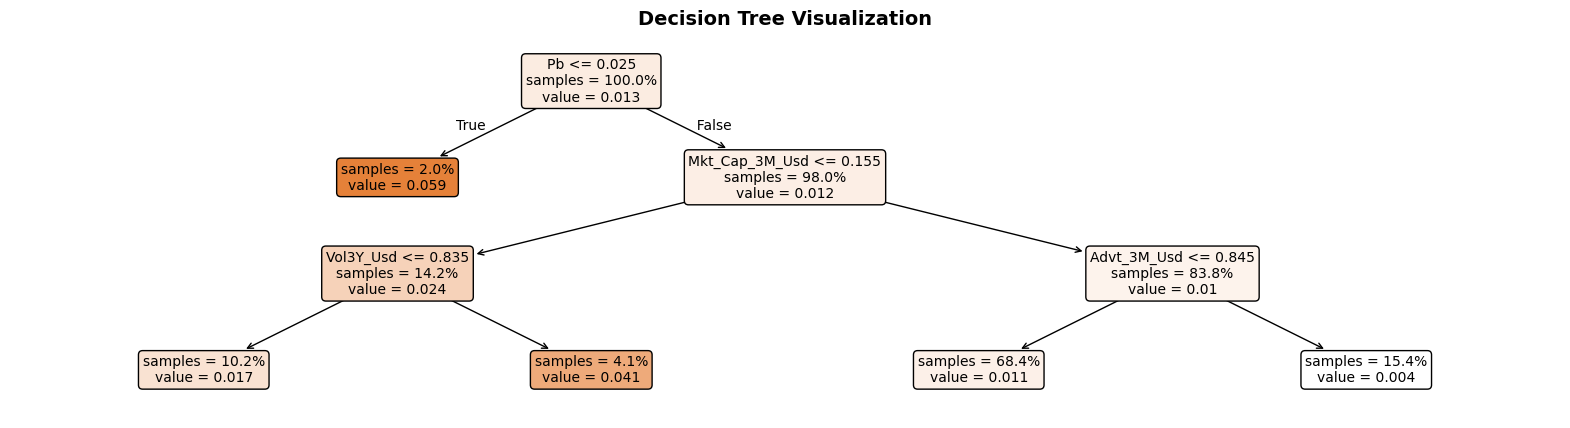

In [11]:
X = data_ml.iloc[:,3:95] # recall features/predictors, full sample
y = data_ml['R1M_Usd'] # recall label/Dependent variable, full sample

# Define and fit the model
fit_tree = tree.DecisionTreeRegressor(
    min_samples_split=8000,
    max_depth=3,
    ccp_alpha=0.000001,
    min_samples_leaf=3500
)
fit_tree.fit(X, y)

# Improve the tree plot
fig, ax = plt.subplots(figsize=(20, 5))  # Increase figure size
tree.plot_tree(
    fit_tree, 
    feature_names=X.columns.values, 
    filled=True, 
    rounded=True, 
    fontsize=10, 
    impurity=False,
    proportion=True
)

plt.title("Decision Tree Visualization", fontsize=14, fontweight="bold")  # Add title
plt.show()


We can see that not all leafs include the same amount of observations. This is not favorable since it can mean some leafs are flukes and will not generalize well out of sample.

The prediction for any instance is the average value of the label within the cluster where the instance should land.

As a verification of the first splits, we plot the smoothed average of future returns, conditionally on market capitalization, price-to-book ratio and trading volume. The graph shows the relevance of clusters based on market capitalizations and price-to-book ratios. For low score values of these two features, the average return is high (close to +4\% on a monthly basis on the left of the curves). The pattern is more pronounced compared to volume for instance.

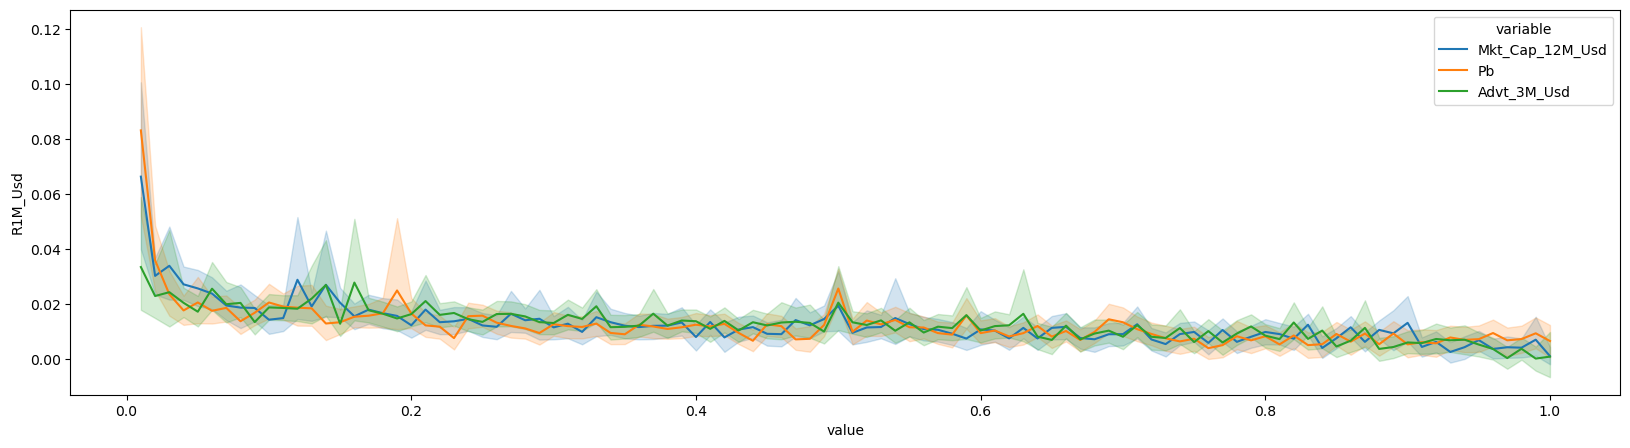

In [9]:
unpivoted_data_ml = pd.melt(data_ml[['R1M_Usd','Mkt_Cap_12M_Usd','Pb','Advt_3M_Usd']], id_vars='R1M_Usd') # selecting and putting in vector
fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data = unpivoted_data_ml, y='R1M_Usd', x='value', hue='variable'); # Plot from seaborn

#### <span style='color:#008080'> Train and test data  </span> 

Below we have created test and train data in order to test how well the model performs out of sample predictions.

In [12]:
# Define test and train data
separation_date = "2014-01-15"
training_sample = data_ml[(data_ml['date'] < separation_date)]
testing_sample = data_ml[(data_ml['date'] >= separation_date)]

Calculate prediction fit

In [13]:
y_train = training_sample['R1M_Usd'].values
X_train = training_sample[features].values
y_test = testing_sample['R1M_Usd'].values
X_test = testing_sample[features].values


fit_tree2 = tree.DecisionTreeRegressor( # Definining the model
  min_samples_split = 4000, # Min nb of obs required to continue splitting
  max_depth = 5, # Maximum depth (i.e. tree levels)
  ccp_alpha=0.0001, # complexity parameters
  min_samples_leaf =1500 # Min nb of obs required in each terminal node (leaf)
        )
fit_tree2 = fit_tree2.fit(X_train, y_train) # Fitting the model

mse = np.mean((fit_tree2.predict(X_test) - y_test)**2)
print(f'MSE: {mse}')
hitratio = np.mean(fit_tree2.predict(X_test) * y_test > 0)
print(f'Hit Ratio: {hitratio}')

MSE: 0.036996958091850045
Hit Ratio: 0.5460346399270738


We can see that we correctly identify returns in **54.6%** of cases.

## <span style='color:#008080'> Random forests  </span> 

These models seek to combine simple trees (bad models) into one tree (good model).

### <span style='color:#008080'> Principle  </span> 

There are two ways to create multiple predictors from simple trees, and random forests combine both

- first, the model can be trained on similar yet different datasets. One way to achieve this is via bootstrap.
- second, the data can be altered by curtailing the number of predictors. Alternative models are built based on different sets of features. The user chooses how many features to retain and then the algorithm selects these features randomly at each try.

Ensemble is simply a weighted combination of all trees. Usually, equal weights are used, which is an agnostic and robust choice.

*NB: As the amount of trees grow toward infinity the inaccuracy converges, which means random forests are not prone to overfitting*.

### <span style='color:#008080'> Code and interpretation  </span> 

#### <span style='color:#008080'> Random forrest regression  </span> 

Below, we train a model and exhibit the predictions for the first 5 instances of the testing sample.

In [ ]:
fit_RF = RandomForestRegressor(
    n_estimators=40, 
    criterion='squared_error',
    min_samples_split= 250, 
    bootstrap=True, 
    max_features=30,
    max_samples=10000
)

fit_RF.fit(X_train, y_train)
fit_RF.predict(pd.DataFrame(X_test).iloc[0:5,])

array([0.09771544, 0.09950529, 0.16824827, 0.16847965, 0.1079016 ])

Each instance has its own prediction, which contrasts with the outcome of simple tree-based outcomes.

The model accuracy is shown below:

In [80]:
mse=mean_squared_error(y_test, fit_RF.predict(X_test))
print(f'MSE: {mse}')
hitratio = np.mean(fit_RF.predict(X_test) * y_test > 0)
print(f'Hit Ratio: {hitratio}')

MSE: 0.03699390385015481
Hit Ratio: 0.5382719917958068


The MSE is smaller than 4% and the hit ratio is close to 54%, which is reasonably above both 50% and 52% thresholds.

#### <span style='color:#008080'> Random forrest classifier  </span> 

Below a random forrest classifier has been run which seeks to model categorical variables.

In [19]:
y_c_train = training_sample['R1M_Usd_C']
y_c_test = testing_sample['R1M_Usd_C']
fit_RF_C = RandomForestClassifier( 
    n_estimators = 40,
    criterion ='gini',
    min_samples_split= 250,
    bootstrap=True, 
    max_features=30,
    max_samples=20000)
fit_RF_C=fit_RF_C.fit(X_train, y_c_train) 

We can then assess the proportion of correct (binary) guesses.

In [20]:
hitratio = np.mean(fit_RF_C.predict(X_test) == y_c_test)
print(f'Hit Ratio: {hitratio}')

Hit Ratio: 0.5014955560619873


There are two potential explanations for disappointing accuracy (beyond the possibility of very different patterns in the training and testing sets): 

1. The sample size, which may be too small.
2. The number of predictors, which is set to 30, i.e., one third of the total at our disposal. (**The usual amount of predictors is $\sqrt{p}$ and $\frac{p}{3}$, where $p$, for classification and regression, respectively. $p$ is the amount of total features.**)

## <span style='color:#008080'> Boosted trees: Adaboost  </span> 

In boosting, it is sought to iteratively improve the model whenever a new tree is added. 

**Adaboost**: improves the learning process by progressively focusing on the instances that yield the largest errors.

### <span style='color:#008080'> Methodology  </span> 

**General structure of the algorithm**:

- Set equal weights $w_{i} = I^{-1}$;
- For $m = 1,\dots, M$ do
    1. Find a learner $l_{m}$ that minimizes the weighted loss $\sum _{i=1}^{I}w_{i}L(l_{m}(\mathbf{x}_{i}), \mathbf{y}_{i})$.
    2. Compute a learner weight
\begin{equation*}
    a_{m} = f_{a}(\mathbf{w}, l_{m}(\mathbf{x}), \mathbf{y});
\end{equation*}
    3. Update the instance weights
\begin{equation*}
    w_{i} \leftarrow w_{i} e^{ f_{w}(l_{m}(\mathbf{x}_{i}), \mathbf{y}_{i}) };
\end{equation*}
    4. Normalize the $w_{i}$ to sum to one;
- The output of the instance $x_{i}$ is a simple function of $\sum _{m=1}^{M}a_{m}l_{m}(\mathbf{x}_{i})$
\begin{equation*}
    \tilde{y}_{i} = f_{y} \left(\sum _{m=1}^{M}a_{m}l_{m}(\mathbf{x}_{i})\right)
\end{equation*}

Below is an explanation of the steps: 
- **First step**: Find a tree ($l_{m}$) that minimizes a weighted loss. *Loss function depends on application*.
- **Second and third step**: Define the way the algorithm adapts sequentially. A property of $f_{a}$  should be that a learner that yields a smaller error should have a larger weight because it is more accurate.
- **Third step**: Change the weights of observations; Since the models seeks to improve the learning process, $f_{w}$ is constructed to give more weight on observations for which the current model does not do a good job.
- **Fourth step**: The final step is a scaling procedure.


The table below shows some different functions depending on application:

|                                | Bin. classification | Regression |
|--------------------------------|---------------------|------------|
| **Individual error**           | $ \epsilon _{i} = \mathbf{1}_{\{ y_{i} \neq  l_{m}(\mathbf{x}_{i}) \} }$ | $\epsilon_i=\frac{\lvert 	y_i- l_m(\textbf{x}_i) \rvert 	}{\underset{i}{\max} \lvert y_i- l_m(\textbf{x}_i) \rvert }$ |
| **Weight of learner via $f_{a}$** | $f_{a} = \log \left(\frac{1-\epsilon }{\epsilon } \right)$ with $\epsilon  = I^{-1} \sum _{i=1}^{I} w_{i} \epsilon _{i}$, | $f_{a} = \log \left(\frac{1-\epsilon }{\epsilon } \right)$ with $\epsilon  = I^{-1} \sum _{i=1}^{I} w_{i} \epsilon _{i}$ |
| **Weight of instances via $f_{w}(i)$** |  $f_{w} = f_{a}\epsilon _{i}$ | $f_{w} = f_{a}\epsilon _{i}$ |
| **Output function via $f_{y}$ ** | $f_{y}(x) = \mathrm{sign}(x)$ | weighted median of predictions |


Jeg skriver lidt noter. Nøj hvor er det fedt!